In [305]:
import csv
import pickle
import re
from datetime import datetime
import numpy as np
# randn = np.random.randn
from pandas import *
import pandas as pd
import matplotlib.pyplot as plt
import statsmodels.formula.api as smf
from scipy.stats import linregress
from pylab import *
from urllib import urlopen
from sklearn.cross_validation import train_test_split
from sklearn.linear_model import LogisticRegression
from __future__ import division
from sklearn import cross_validation
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.cross_validation import cross_val_score
from sklearn.metrics import precision_recall_fscore_support
from sklearn import metrics
from sklearn.metrics import roc_curve, auc
from sklearn.metrics import roc_auc_score
from sklearn.preprocessing import label_binarize
from sklearn import tree
from sklearn.externals.six import StringIO
import os
from sklearn.externals.six import StringIO  
import pydot
from sklearn.cross_validation import StratifiedKFold


## Variables Pre-processing

1 (?) - emp.var.rate = 1-value

2 (?) - euribor3m = 1/value

3 - job = 1 if student or retired, 0 if other

4 - marital = 1 if single, 0 if other

5 (?) - poutcome = 1 if success 0 if other

6 - age = ((exp^((value-47)/3))-(exp^-((value-47)/3))/2 (lowest 36-58 highest 19 and 77)

7 - campaign = 1/value (NO)

8 (?) - pdays = 1 if < 999 0 if = 999 (as "contacted before?")

9 (?) - previous = 1 if != 0

10 (?) - month

In [306]:
#math.exp(x) = e ** x
#math.expm1(x) = e ** -x
#Hyperbola centered around y axis to describe age influence (too steep)
#ex = math.exp((x-47)/3)
#emx = math.exp(-(x-47)/3)
#y = ((ex)+(emx))/2
#age = (y-1)/5000

In [307]:
bank_full = read_csv('bank-additional-full.csv', delimiter=';', header=0)
bank_full.head(3)

,age,job,marital,education,default,housing,loan,contact,month,day_of_week,...,campaign,pdays,previous,poutcome,emp.var.rate,cons.price.idx,cons.conf.idx,euribor3m,nr.employed,y
0,56,housemaid,married,basic.4y,no,no,no,telephone,may,mon,...,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191,no
1,57,services,married,high.school,unknown,no,no,telephone,may,mon,...,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191,no
2,37,services,married,high.school,no,yes,no,telephone,may,mon,...,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191,no


In [308]:
bank = bank_full[['age','contact','pdays','previous','poutcome','emp.var.rate','euribor3m','y']]
#bank = bank_full[['age','job','marital','contact','pdays','previous','poutcome','emp.var.rate','euribor3m','y']]
#bank = bank_full[['age','job','campaign','pdays','poutcome','emp.var.rate','euribor3m','y']]
#bank = bank_full[['age','job','y']]
bank.head(3)

,age,contact,pdays,previous,poutcome,emp.var.rate,euribor3m,y
0,56,telephone,999,0,nonexistent,1.1,4.857,no
1,57,telephone,999,0,nonexistent,1.1,4.857,no
2,37,telephone,999,0,nonexistent,1.1,4.857,no


In [309]:
bank['y'] = bank['y'].map({'yes': 1, 'no': 0})

/usr/local/lib/python2.7/site-packages/IPython/kernel/__main__.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  if __name__ == '__main__':


In [310]:
bank['age'] =((bank['age']-47)/30) ** 2
#bank['age'][bank['age'] < 36] = abs((bank['age']-36)/19)
#bank['age'][bank['age'] >= 36] = 0
#bank['age'][bank['age'] > 58] = abs((bank['age']-58)/19)
bank['age'][bank['age'] > 1] = 1

/usr/local/lib/python2.7/site-packages/IPython/kernel/__main__.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  if __name__ == '__main__':
/usr/local/lib/python2.7/site-packages/IPython/kernel/__main__.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


In [311]:
#bank['job'][bank['job'] == 'student'] = 1
#bank['job'][bank['job'] == 'retired'] = 1
#bank['job'][bank['job'] != 1] = 0

In [312]:
#bank['marital'][bank['marital'] == 'single'] = 1
#bank['marital'][bank['marital'] != 1] = 0

In [313]:
bank['contact'][bank['contact'] == 'cellular'] = 1
bank['contact'][bank['contact'] != 1] = 0

/usr/local/lib/python2.7/site-packages/IPython/kernel/__main__.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  if __name__ == '__main__':
/usr/local/lib/python2.7/site-packages/IPython/kernel/__main__.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  from IPython.kernel.zmq import kernelapp as app


In [314]:
bank['pdays'][bank['pdays'] != 999] = 1
bank['pdays'][bank['pdays'] == 999] = 0

/usr/local/lib/python2.7/site-packages/IPython/kernel/__main__.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  if __name__ == '__main__':
/usr/local/lib/python2.7/site-packages/IPython/kernel/__main__.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  from IPython.kernel.zmq import kernelapp as app


In [315]:
bank['previous'][bank['previous'] != 0] = 1
bank['previous'][bank['previous'] != 1] = 0

/usr/local/lib/python2.7/site-packages/IPython/kernel/__main__.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  if __name__ == '__main__':
/usr/local/lib/python2.7/site-packages/IPython/kernel/__main__.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  from IPython.kernel.zmq import kernelapp as app


In [316]:
bank['poutcome'][bank['poutcome'] == 'failure'] = 0
bank['poutcome'][bank['poutcome'] == 'nonexistent'] = 0
bank['poutcome'][bank['poutcome'] == 'success'] = 1

/usr/local/lib/python2.7/site-packages/IPython/kernel/__main__.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  if __name__ == '__main__':
/usr/local/lib/python2.7/site-packages/IPython/kernel/__main__.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  from IPython.kernel.zmq import kernelapp as app
/usr/local/lib/python2.7/site-packages/IPython/kernel/__main__.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  app.launch_new_instance()


In [317]:
bank['emp.var.rate'] = abs((bank['emp.var.rate'] - 1.4) / 4.8)

/usr/local/lib/python2.7/site-packages/IPython/kernel/__main__.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  if __name__ == '__main__':


In [318]:
bank['euribor3m'] = 1 - (bank['euribor3m'] / 5.5)

/usr/local/lib/python2.7/site-packages/IPython/kernel/__main__.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  if __name__ == '__main__':


In [319]:
bank.head(5)

,age,contact,pdays,previous,poutcome,emp.var.rate,euribor3m,y
0,0.090000,0,0,0,0,0.0625,0.116909,0
1,0.111111,0,0,0,0,0.0625,0.116909,0
2,0.111111,0,0,0,0,0.0625,0.116909,0
3,0.054444,0,0,0,0,0.0625,0.116909,0
4,0.090000,0,0,0,0,0.0625,0.116909,0


In [320]:
byes = bank[bank['y'] == 1]
bno = bank[bank['y'] == 0]

In [321]:
len(byes)

4640

In [322]:
len(bno)

36548

In [323]:
# 'age','job','marital','contact','month','pdays','previous','poutcome','emp.var.rate','euribor3m'

In [324]:
mean(byes)
#mean((byes['age'] + byes['job'] + byes['marital'] + byes['contact'] + byes['pdays'] + byes['previous'] + byes['poutcome'] + byes['emp.var.rate'] + byes['euribor3m']) / 9)
#mean((byes['age'] + byes['job']) / 3)

age             0.244659
contact         0.830388
pdays           0.208405
previous        0.323060
poutcome        0.192672
emp.var.rate    0.548635
euribor3m       0.613975
y               1.000000
dtype: float64

In [325]:
mean(bno)
#mean((bno['age'] + bno['job'] + bno['marital'] + bno['contact'] + bno['pdays'] + bno['previous'] + bno['poutcome'] + bno['emp.var.rate'] + bno['euribor3m']) / 9)
#mean((bno['age'] + bno['job']) / 3)

age             0.163570
contact         0.609910
pdays           0.014994
previous        0.112893
poutcome        0.013106
emp.var.rate    0.239818
euribor3m       0.307002
y               0.000000
dtype: float64

In [326]:
X = bank.drop('y', 1)
y = bank['y']

X_train, X_test, y_train, y_test = cross_validation.train_test_split(X, y, test_size=0.20, random_state=0)

In [327]:
print X.shape, X_train.shape, X_test.shape

(41188, 7) (32950, 7) (8238, 7)


In [328]:
acc_scores = {}
for n in range(20):
    clf = KNeighborsClassifier(n_neighbors=(n+1)).fit(X_train, y_train)
    y_pred_knn = clf.predict(X_test)
    acc_scores.setdefault((n+1), [])
    acc_scores[(n+1)].append(accuracy_score(y_test, y_pred_knn))

In [329]:
print acc_scores

{1: [0.86088856518572465], 2: [0.8934207331876669], 3: [0.88868657441126486], 4: [0.89584850691915519], 5: [0.89172129157562519], 6: [0.89584850691915519], 7: [0.89390628793396454], 8: [0.89766933721777131], 9: [0.89694100509832486], 10: [0.896091284292304], 11: [0.89766933721777131], 12: [0.89791211459092013], 13: [0.89669822772517604], 14: [0.89730517115804809], 15: [0.89718378247147368], 16: [0.89851905802379217], 17: [0.89839766933721776], 18: [0.89766933721777131], 19: [0.89706239378489927], 20: [0.89718378247147368]}


In [330]:
nmax = max(acc_scores, key=acc_scores.get)
nmax

16

In [331]:
clf = KNeighborsClassifier(n_neighbors = (nmax))
knn_model = clf.fit(X_train, y_train)
y_pred_knn = knn_model.predict(X_test)
y_proba_knn = knn_model.predict_proba(X_test)
accuracy_score(y_test, y_pred_knn)

0.89851905802379217

In [332]:
X_test = X_test.astype(float)
log_model = LogisticRegression()
log_model = log_model.fit(X_train, y_train)
y_pred_log = log_model.predict(X_test)
y_proba_log = log_model.predict_proba(X_test)
accuracy_score(y_test, y_pred_log)

0.89839766933721776

In [333]:
clf = GaussianNB()
gnb_model = clf.fit(X_train, y_train)
y_pred_gnb = gnb_model.predict(X_test)
y_proba_gnb = gnb_model.predict_proba(X_test)
accuracy_score(y_test, y_pred_gnb)

0.88055353241077927

In [334]:
clf = SVC(probability=True)
svc_model = clf.fit(X_train, y_train)
y_pred_svc = svc_model.predict(X_test)
y_proba_svc = svc_model.predict_proba(X_test)
accuracy_score(y_test, y_pred_svc)

0.8975479485311969

In [335]:
clf = DecisionTreeClassifier()
dtc_model = clf.fit(X_train, y_train)
y_pred_dtc = dtc_model.predict(X_test)
y_proba_dtc = dtc_model.predict_proba(X_test)
accuracy_score(y_test, y_pred_dtc)

0.88965768390386013

In [336]:
clf = RandomForestClassifier()
rfc_model = clf.fit(X_train, y_train)
y_pred_rfc = rfc_model.predict(X_test)
y_proba_rfc = rfc_model.predict_proba(X_test)
accuracy_score(y_test, y_pred_rfc)

0.89172129157562519

In [337]:
#clf = tree.DecisionTreeClassifier()
#tdt_model = clf.fit(X_train, y_train)
#y_pred_tdt = tdt_model.predict(X_test)
#y_proba_tdt = tdt_model.predict_proba(X_test)
#accuracy_score(y_test, y_pred_tdt)

In [338]:
#with open("bank.dot", 'w') as f:
#    f = tree.export_graphviz(clf, out_file=f)
#os.unlink('bank.dot')
#dot_data = StringIO() 
#tree.export_graphviz(clf, out_file=dot_data) 
#graph = pydot.graph_from_dot_data(dot_data.getvalue()) 
#graph.write_pdf("bank.pdf")

# GLM ?

In [339]:
fpr, tpr, thresholds = metrics.roc_curve(y_test, y_proba_knn[:,1])
roc_auc_knn = auc(fpr, tpr)
precision_recall_fscore_support(y_test, y_pred_knn, pos_label = None, average = None)

(array([ 0.91172361,  0.61369863]),
 array([ 0.98073507,  0.2437432 ]),
 array([ 0.94497104,  0.34890966]),
 array([7319,  919]))

Populating the interactive namespace from numpy and matplotlib


`%matplotlib` prevents importing * from pylab and numpy


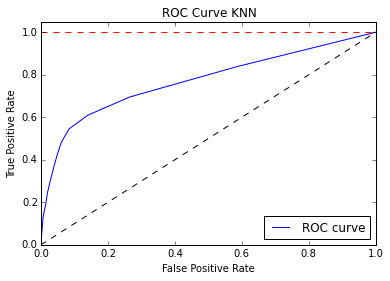

In [340]:
%pylab inline
plt.figure()
plt.plot(fpr, tpr, label='ROC curve' % roc_auc_knn)
plt.plot([0, 1], [0, 1], 'k--')
plt.plot([0, 1], [1, 1], 'r--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve KNN')
plt.legend(loc="lower right")
plt.show()

In [341]:
fpr, tpr, thresholds = metrics.roc_curve(y_test, y_proba_log[:,1])
roc_auc_log = auc(fpr, tpr)
precision_recall_fscore_support(y_test, y_pred_log, pos_label = None, average = None)

(array([ 0.9071608 ,  0.64748201]),
 array([ 0.98661019,  0.19586507]),
 array([ 0.94521893,  0.30075188]),
 array([7319,  919]))

Populating the interactive namespace from numpy and matplotlib


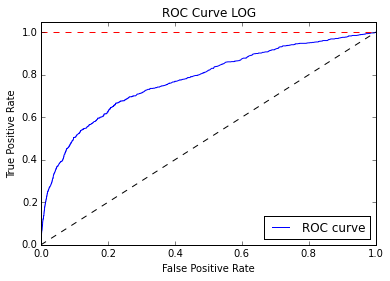

In [342]:
%pylab inline
plt.figure()
plt.plot(fpr, tpr, label='ROC curve' % roc_auc_log)
plt.plot([0, 1], [0, 1], 'k--')
plt.plot([0, 1], [1, 1], 'r--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve LOG')
plt.legend(loc="lower right")
plt.show()

In [343]:
fpr, tpr, thresholds = metrics.roc_curve(y_test, y_proba_gnb[:,1])
roc_auc_gnb = auc(fpr, tpr)
precision_recall_fscore_support(y_test, y_pred_gnb, pos_label = None, average = None)

(array([ 0.9165023 ,  0.44865719]),
 array([ 0.95231589,  0.30903156]),
 array([ 0.93406593,  0.36597938]),
 array([7319,  919]))

Populating the interactive namespace from numpy and matplotlib


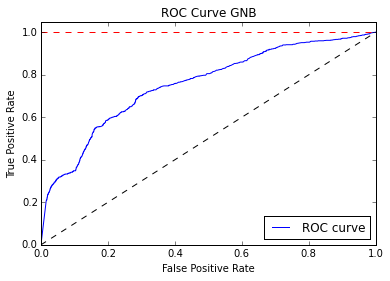

In [344]:
%pylab inline
plt.figure()
plt.plot(fpr, tpr, label='ROC curve' % roc_auc_gnb)
plt.plot([0, 1], [0, 1], 'k--')
plt.plot([0, 1], [1, 1], 'r--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve GNB')
plt.legend(loc="lower right")
plt.show()

In [345]:
fpr, tpr, thresholds = metrics.roc_curve(y_test, y_proba_svc[:,1])
roc_auc_svc = auc(fpr, tpr)
precision_recall_fscore_support(y_test, y_pred_svc, pos_label = None, average = None)

(array([ 0.90800252,  0.62376238]),
 array([ 0.9844241 ,  0.20565832]),
 array([ 0.94467025,  0.30932897]),
 array([7319,  919]))

Populating the interactive namespace from numpy and matplotlib


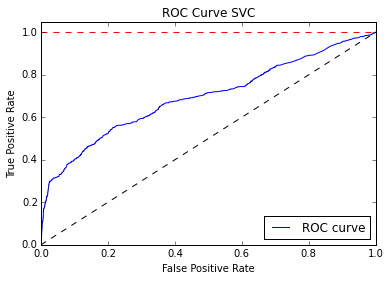

In [346]:
%pylab inline
plt.figure()
plt.plot(fpr, tpr, label='ROC curve' % roc_auc_svc)
plt.plot([0, 1], [0, 1], 'k--')
plt.plot([0, 1], [1, 1], 'r--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve SVC')
plt.legend(loc="lower right")
plt.show()

In [347]:
fpr, tpr, thresholds = metrics.roc_curve(y_test, y_proba_dtc[:,1])
roc_auc_dtc = auc(fpr, tpr)
precision_recall_fscore_support(y_test, y_pred_dtc, pos_label = None, average = None)

(array([ 0.91461837,  0.50984252]),
 array([ 0.96597896,  0.28182807]),
 array([ 0.93959732,  0.3629993 ]),
 array([7319,  919]))

Populating the interactive namespace from numpy and matplotlib


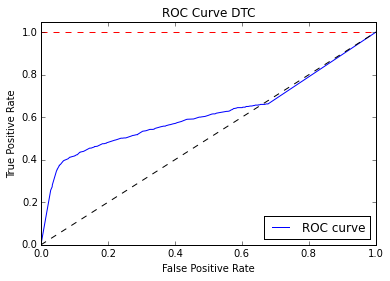

In [348]:
%pylab inline
plt.figure()
plt.plot(fpr, tpr, label='ROC curve' % roc_auc_dtc)
plt.plot([0, 1], [0, 1], 'k--')
plt.plot([0, 1], [1, 1], 'r--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve DTC')
plt.legend(loc="lower right")
plt.show()

In [349]:
fpr, tpr, thresholds = metrics.roc_curve(y_test, y_proba_rfc[:,1])
roc_auc_rfc = auc(fpr, tpr)
precision_recall_fscore_support(y_test, y_pred_rfc, pos_label = None, average = None)

(array([ 0.91674232,  0.5256167 ]),
 array([ 0.96584233,  0.30141458]),
 array([ 0.94065203,  0.38312586]),
 array([7319,  919]))

Populating the interactive namespace from numpy and matplotlib


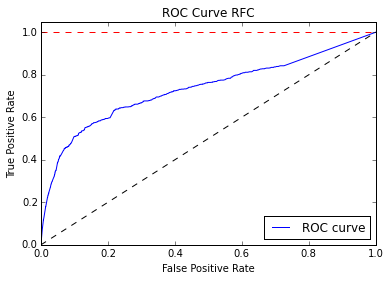

In [350]:
%pylab inline
plt.figure()
plt.plot(fpr, tpr, label='ROC curve' % roc_auc_rfc)
plt.plot([0, 1], [0, 1], 'k--')
plt.plot([0, 1], [1, 1], 'r--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve RFC')
plt.legend(loc="lower right")
plt.show()

In [351]:
roc_auc_knn

0.77070434383000941

In [352]:
roc_auc_log

0.77639354752287371

In [353]:
roc_auc_gnb

0.75365635761617955

In [354]:
roc_auc_svc

0.69461428294684002

In [355]:
roc_auc_dtc

0.6217477547742315

In [356]:
roc_auc_rfc

0.73335086686149797

In [357]:
X = X.astype(float)
cv = StratifiedKFold(y, n_folds=6)

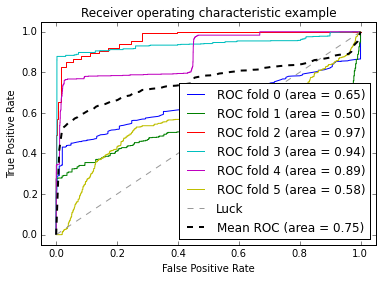

In [358]:
classifier = LogisticRegression()
mean_tpr = 0.0
mean_fpr = np.linspace(0, 1, 100)
all_tpr = []

for i, (train, test) in enumerate(cv):
    # Compute ROC curve and area the curve
    probas_ = classifier.fit(X.iloc[train,:], y[train]).predict_proba(X.iloc[test,:])
    fpr, tpr, thresholds = roc_curve(y[test], probas_[:,1])
    mean_tpr += interp(mean_fpr, fpr, tpr)
    mean_tpr[0] = 0.0
    roc_auc = auc(fpr, tpr)
    plt.plot(fpr, tpr, lw=1, label='ROC fold %d (area = %0.2f)' % (i, roc_auc))

plt.plot([0, 1], [0, 1], '--', color=(0.6, 0.6, 0.6), label='Luck')

mean_tpr /= len(cv)
mean_tpr[-1] = 1.0
mean_auc = auc(mean_fpr, mean_tpr)
plt.plot(mean_fpr, mean_tpr, 'k--',
         label='Mean ROC (area = %0.2f)' % mean_auc, lw=2)

plt.xlim([-0.05, 1.05])
plt.ylim([-0.05, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic example')
plt.legend(loc="lower right")

In [361]:
px2 = X_test.reshape((-1,7))
#px2 = X_test.reshape((-1,9))
#'age','job','marital','contact','month','pdays','previous','poutcome','emp.var.rate','euribor3m'
X_err = pd.DataFrame({'age':px2[:,0],'contact':px2[:,1],'pdays':px2[:,2],'previous':px2[:,3],'poutcome':px2[:,4],'emp.var.rate':px2[:,5],'euribor3m':px2[:,6]})
#X_err = pd.DataFrame({'age':px2[:,0],'job':px2[:,1],'marital':px2[:,2],'contact':px2[:,3],'pdays':px2[:,4],'previous':px2[:,5],'poutcome':px2[:,6],'emp.var.rate':px2[:,7],'euribor3m':px2[:,8]})

In [362]:
y_err = y_pred_log - y_test

In [363]:
indneg = []
indpos = []
for r in range(len(y_err)):
    if y_err[r] == 1:
        indpos.append(r)
    if y_err[r] == -1:
        indneg.append(r)

print len(indneg), len(indpos)

739 98


In [364]:
X_err_neg = X_err.iloc[indneg,:]

In [365]:
mean(X_err_neg)

age             0.232616
contact         0.803789
emp.var.rate    0.498224
euribor3m       0.551895
pdays           0.012179
poutcome        0.001353
previous        0.140731
dtype: float64

In [366]:
mean(byes)

age             0.244659
contact         0.830388
pdays           0.208405
previous        0.323060
poutcome        0.192672
emp.var.rate    0.548635
euribor3m       0.613975
y               1.000000
dtype: float64

In [367]:
X_err_pos = X_err.iloc[indpos,:]

In [368]:
mean(X_err_pos)

age             0.282256
contact         0.908163
emp.var.rate    0.756590
euribor3m       0.828419
pdays           1.000000
poutcome        0.897959
previous        1.000000
dtype: float64

In [369]:
mean(bno)

age             0.163570
contact         0.609910
pdays           0.014994
previous        0.112893
poutcome        0.013106
emp.var.rate    0.239818
euribor3m       0.307002
y               0.000000
dtype: float64